In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

# 1000 synthetic transactions
data = {
    "transaction_id": np.arange(1, 1001),
    "customer_id": np.random.randint(10000, 20000, 1000),
    "amount": np.round(np.random.uniform(10, 50000, 1000), 2),
    "timestamp": pd.date_range(start='2024-01-01', periods=1000, freq='H'),
    "location": np.random.choice(["Mumbai", "Delhi", "Pune", "Bengaluru"], 1000),
    "device": np.random.choice(["Mobile", "Web", "ATM"], 1000),
}

df = pd.DataFrame(data)

# Label fraud (amount-based + randomness)
df["is_fraud"] = np.where(
    (df["amount"] > 30000) & (np.random.rand(1000) > 0.7), 1, 0
)

df.head()


/tmp/ipython-input-2079367365.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  "timestamp": pd.date_range(start='2024-01-01', periods=1000, freq='H'),


,transaction_id,customer_id,amount,timestamp,location,device,is_fraud
0,1,17270,36307.52,2024-01-01 00:00:00,Bengaluru,Mobile,1
1,2,10860,29652.22,2024-01-01 01:00:00,Mumbai,Web,0
2,3,15390,5119.61,2024-01-01 02:00:00,Pune,Mobile,0
3,4,15191,45938.34,2024-01-01 03:00:00,Pune,Web,0
4,5,15734,39506.33,2024-01-01 04:00:00,Mumbai,ATM,0


In [2]:
import sqlite3

conn = sqlite3.connect("fraud_detection.db")
df.to_sql("transactions", conn, if_exists="replace", index=False)

conn.commit()
conn.close()
print("ETL Completed: Data stored in SQLite 🚀")


ETL Completed: Data stored in SQLite 🚀


In [3]:
conn = sqlite3.connect("fraud_detection.db")
df = pd.read_sql("SELECT * FROM transactions", conn)
conn.close()

# Feature Engineering
df["hour"] = pd.to_datetime(df["timestamp"]).dt.hour

from sklearn.preprocessing import LabelEncoder
encoder_loc = LabelEncoder()
encoder_dev = LabelEncoder()

df["loc_code"] = encoder_loc.fit_transform(df["location"])
df["dev_code"] = encoder_dev.fit_transform(df["device"])


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

features = ["amount", "hour", "loc_code", "dev_code"]
target = "is_fraud"

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target],
                                                    test_size=0.3, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

pred = model.predict(X_test)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.90      0.97      0.93       263
           1       0.47      0.22      0.30        37

    accuracy                           0.87       300
   macro avg       0.68      0.59      0.61       300
weighted avg       0.84      0.87      0.85       300



In [5]:
import pickle

pickle.dump(model, open("fraud_model.pkl", "wb"))
pickle.dump({"loc": encoder_loc, "dev": encoder_dev}, open("encoders.pkl", "wb"))

print("Model + Encoders saved ✔")


Model + Encoders saved ✔


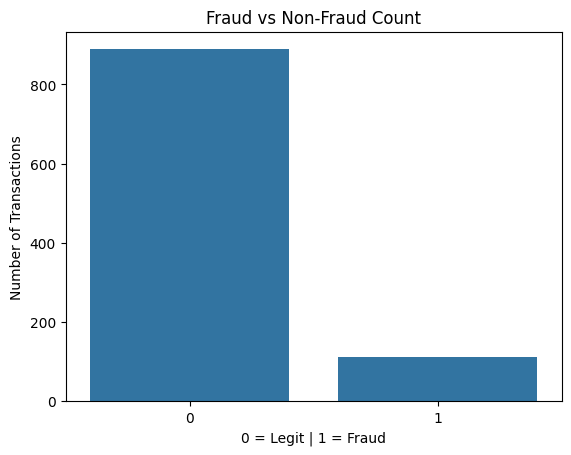

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=df["is_fraud"])
plt.title("Fraud vs Non-Fraud Count")
plt.xlabel("0 = Legit | 1 = Fraud")
plt.ylabel("Number of Transactions")
plt.show()


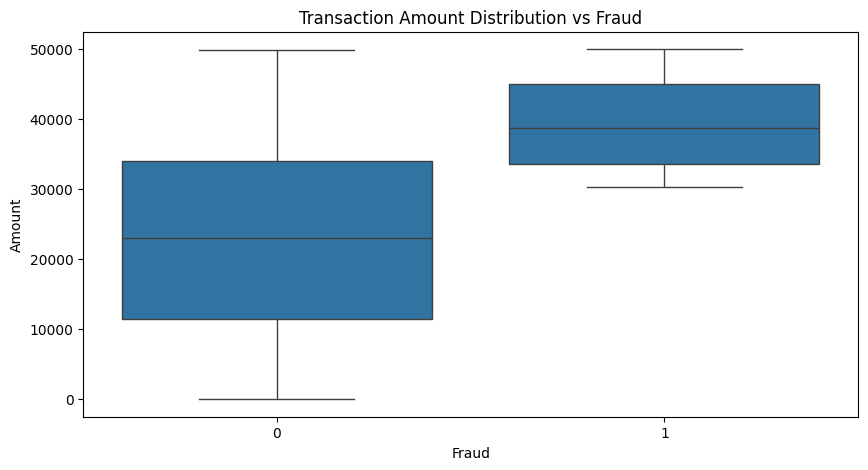

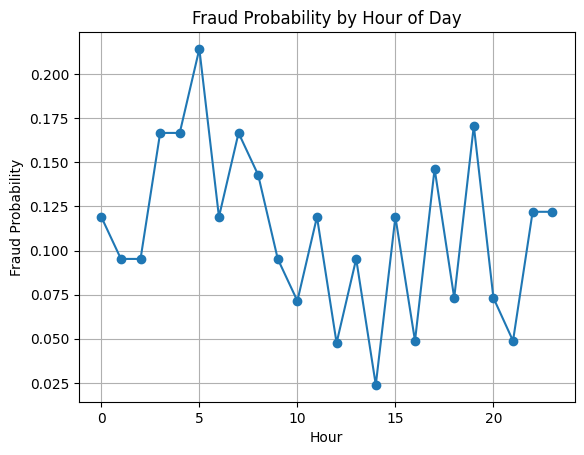

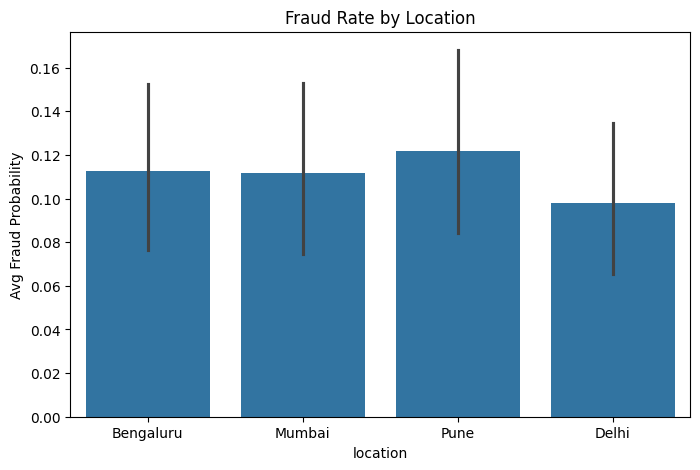

,transaction_id,customer_id,amount,timestamp,location,device,is_fraud,hour,loc_code,dev_code,fraud_risk
171,172,11853,45776.53,2024-01-08 03:00:00,Mumbai,Mobile,1,3,2,1,0.92
123,124,17721,48727.62,2024-01-06 03:00:00,Mumbai,Web,1,3,2,2,0.90
723,724,19550,47733.45,2024-01-31 03:00:00,Bengaluru,Web,1,3,0,2,0.87
172,173,16585,36079.43,2024-01-08 04:00:00,Delhi,Web,1,4,1,2,0.84
752,753,10760,40789.27,2024-02-01 08:00:00,Bengaluru,Web,1,8,0,2,0.83
440,441,17390,35749.05,2024-01-19 08:00:00,Delhi,Web,1,8,1,2,0.82
785,786,16493,31901.66,2024-02-02 17:00:00,Pune,Mobile,1,17,3,1,0.82
395,396,18311,38551.50,2024-01-17 11:00:00,Bengaluru,Mobile,1,11,0,1,0.82
240,241,14548,44251.07,2024-01-11 00:00:00,Bengaluru,Mobile,1,0,0,1,0.82
940,941,15984,39606.76,2024-02-09 04:00:00,Mumbai,Web,1,4,2,2,0.82


In [8]:
plt.figure(figsize=(10,5))
sns.boxplot(x="is_fraud", y="amount", data=df)
plt.title("Transaction Amount Distribution vs Fraud")
plt.xlabel("Fraud")
plt.ylabel("Amount")
plt.show()
fraud_by_hour = df.groupby("hour")["is_fraud"].mean()

plt.plot(fraud_by_hour.index, fraud_by_hour.values, marker='o')
plt.title("Fraud Probability by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Fraud Probability")
plt.grid(True)
plt.show()
plt.figure(figsize=(8,5))
sns.barplot(x="location", y="is_fraud", data=df, estimator=np.mean)
plt.title("Fraud Rate by Location")
plt.ylabel("Avg Fraud Probability")
plt.show()
probs = model.predict_proba(df[["amount","hour","loc_code","dev_code"]])[:,1]
df["fraud_risk"] = probs

top_risky = df.sort_values(by="fraud_risk", ascending=False).head(10)
top_risky
